# Yelp Dataset Analysis - Pub Ratings

In [1]:
import csv
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
from statsmodels.formula.api import ols

from IPython.display import HTML, display
%matplotlib inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import custom restauramt and not_restaurant csv files as dataframes

In [2]:
restaurant_df = pd.read_csv('is_restaurant.csv')
restaurant_df = restaurant_df.drop(['Unnamed: 0','city'], 1)
restaurant_df = restaurant_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
restaurant_df['index_no'] = restaurant_df.index

not_restaurant_df = pd.read_csv('not_restaurant.csv')
not_restaurant_df = not_restaurant_df.drop(['Unnamed: 0','city','distance'], 1)
not_restaurant_df = not_restaurant_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
not_restaurant_df['index_no'] = not_restaurant_df.index


## Rating of Restaurants Based on the Ratings of Other Restaurants Around It

In [3]:
restaurant_rating_df = pd.DataFrame()

def haversine(x):
    
    global restaurant_df
    global restaurant_rating_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(restaurant_df['latitude']), np.radians(restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = restaurant_df
    measure_1 = measure_1.loc[measure_1['distance'] <= 1]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    restaurant_rating_df = restaurant_rating_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return restaurant_rating_df


for line in restaurant_df['index_no']:
    x = restaurant_df.loc[restaurant_df['index_no'] == line]
    haversine(x)


In [4]:
restaurant_rating_df = restaurant_rating_df[restaurant_rating_df.density != 0]

In [5]:
restaurant_rating_df = restaurant_rating_df[(restaurant_rating_df.rating >= 2.5)]
#final_pubs_df.describe()

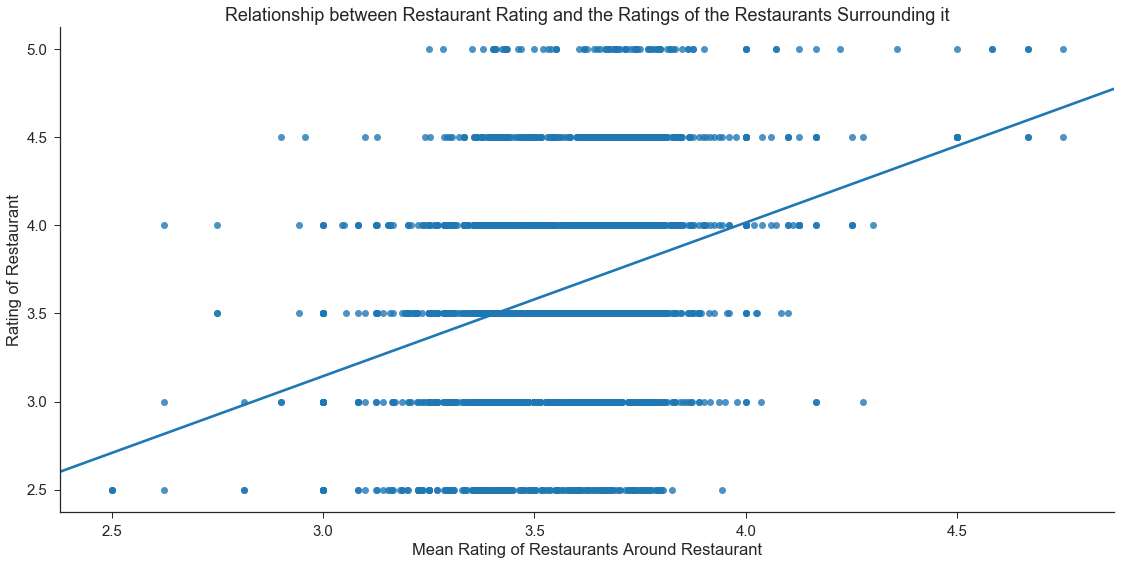

In [6]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8,ci=None, data = restaurant_rating_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Restaurant Rating and the Ratings of the Restaurants Surrounding it")
plt.xlabel('Mean Rating of Restaurants Around Restaurant')
plt.ylabel('Rating of Restaurant')

plt.savefig("Relationship between Restaurant Rating and the Ratings of the Restaurants Surrounding it.png")

In [7]:
restaurant_rating_df.describe()

,density,mean_business_rating,rating
count,3199.000000,3199.000000,3199.000000
mean,25.926136,3.553834,3.626289
std,24.231424,0.218517,0.611025
min,0.159155,2.500000,2.500000
25%,4.933803,3.409091,3.000000
50%,16.392959,3.548387,3.500000
75%,44.722539,3.700000,4.000000
max,81.964796,4.750000,5.000000


In [8]:
restaurant_rating_df['mean_business_rating'].corr(restaurant_rating_df['rating'])

0.31167118728759452

In [9]:
restaurant_model = ols("rating ~ mean_business_rating", data=restaurant_rating_df).fit()
restaurant_model_summary = restaurant_model.summary()
restaurant_model_summary
#restaurant_model.savefig("OLS for Restaurant Rating and the Ratings of the Restaurants Surrounding it.png")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     344.0
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           5.18e-73
Time:                        02:15:19   Log-Likelihood:                -2799.4
No. Observations:                3199   AIC:                             5603.
Df Residuals:                    3197   BIC:                             5615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5291      0.167      3.162      0.002       0.201       0.857
mean_business_rating     0.8715      0.047     18.546      0.000       0.779       0.964
==============================================================================
Omnibus:                       41.785   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.381
Skew:                          -0.004   Prob(JB):                     3.08e-06
Kurtosis:                       2.564   Cond. No.                         62.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

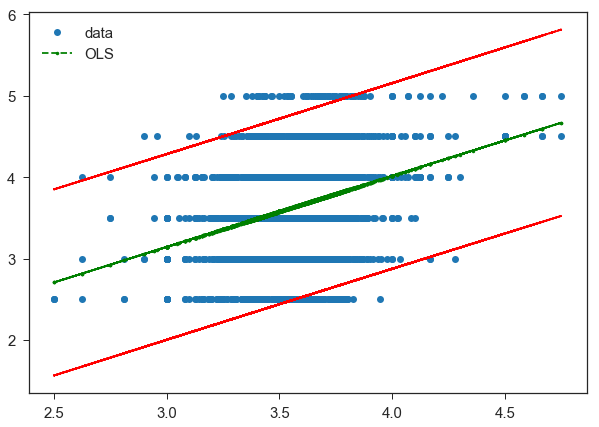

In [10]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# predictor variable
x = restaurant_rating_df[['mean_business_rating']]
# dependent variable
y = restaurant_rating_df[['rating']]

# retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(restaurant_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, restaurant_model.fittedvalues, 'g--.', label="OLS")
# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')
# plot legend
ax.legend(loc='best');


## Ratings of Restaurants Based on Ratings of Non-Restaurant Businesses

In [11]:
final_nonrestaurants_df = pd.DataFrame()

def haversine(x):
    
    global not_restaurant_df
    global final_nonrestaurants_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_restaurant_df['latitude']), np.radians(not_restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_restaurant_df
    measure_1 = measure_1.loc[measure_1['distance'] <= 1.0]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_nonrestaurants_df = final_nonrestaurants_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_nonrestaurants_df


for line in restaurant_df['index_no']:
    x = restaurant_df.loc[restaurant_df['index_no'] == line]
    haversine(x)


In [12]:
final_nonrestaurants_df = final_nonrestaurants_df[(final_nonrestaurants_df.density != 0)]


In [13]:
final_nonrestaurants_df = final_nonrestaurants_df[(final_nonrestaurants_df.mean_business_rating <= 4.2) & (final_nonrestaurants_df.mean_business_rating >= 1.5)]
final_nonrestaurants_df = final_nonrestaurants_df[(final_nonrestaurants_df.rating >= 2.2)]


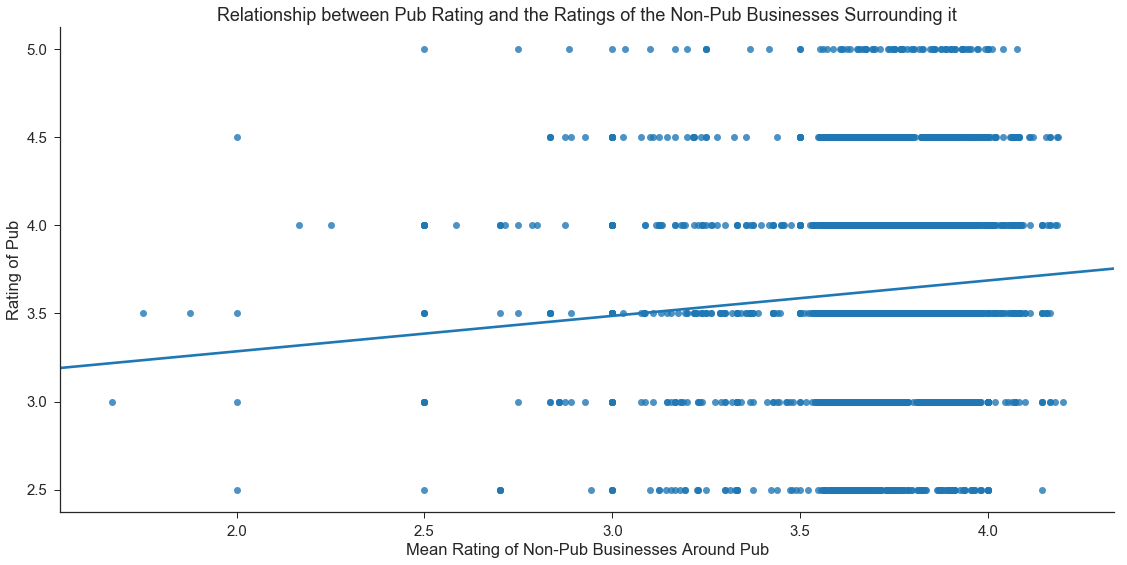

In [14]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8, ci=None, data=final_nonrestaurants_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and the Ratings of the Non-Pub Businesses Surrounding it")
plt.xlabel('Mean Rating of Non-Pub Businesses Around Pub')
plt.ylabel('Rating of Pub')

plt.savefig("Relationship between Pub Rating and the Ratings of the Non-Pub Businesses Surrounding it.png")

In [15]:
final_nonrestaurants_df.describe()

,density,mean_business_rating,rating
count,3062.000000,3062.000000,3062.000000
mean,29.501983,3.692707,3.624918
std,25.953665,0.261302,0.608652
min,0.159155,1.666667,2.500000
25%,6.565141,3.614686,3.000000
50%,20.690143,3.696203,3.500000
75%,54.112681,3.864447,4.000000
max,85.307049,4.200000,5.000000


In [16]:
final_nonrestaurants_df['mean_business_rating'].corr(final_nonrestaurants_df['rating'])

0.086279178659730005

In [17]:
non_restaurant_model = ols("rating ~ mean_business_rating", data=final_nonrestaurants_df).fit()
non_restaurant_model_summary = restaurant_model.summary()
non_restaurant_model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     344.0
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           5.18e-73
Time:                        02:15:51   Log-Likelihood:                -2799.4
No. Observations:                3199   AIC:                             5603.
Df Residuals:                    3197   BIC:                             5615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5291      0.167      3.162      0.002       0.201       0.857
mean_business_rating     0.8715      0.047     18.546      0.000       0.779       0.964
==============================================================================
Omnibus:                       41.785   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.381
Skew:                          -0.004   Prob(JB):                     3.08e-06
Kurtosis:                       2.564   Cond. No.                         62.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

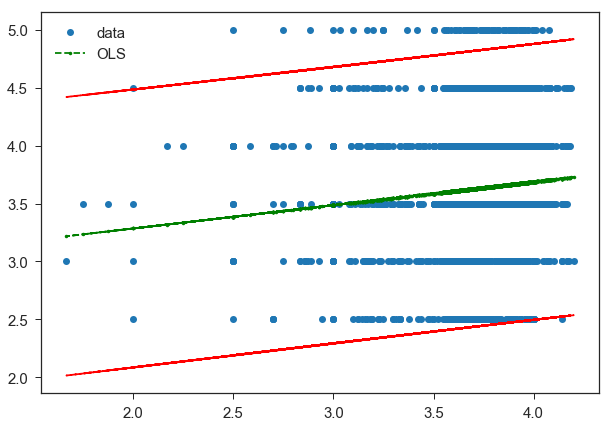

In [18]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# predictor variable
x = final_nonrestaurants_df[['mean_business_rating']]
# dependent variable
y = final_nonrestaurants_df[['rating']]

# retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(non_restaurant_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, non_restaurant_model.fittedvalues, 'g--.', label="OLS")
# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')
# plot legend
ax.legend(loc='best');

fig.savefig("CI for Restaurant and Mean Business Rating.png")

# Quality and Quantity

We are interested in understanding if quality drives competition and market size. 

In [25]:
restaurant_count_df = pd.DataFrame()

def haversine(x):
    
    global restaurant_df
    global restaurant_count_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(restaurant_df['latitude']), np.radians(restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = restaurant_df
    measure_1 = measure_1.loc[restaurant_df['distance'] <=1]
    
    # Calculate the number of pubs
    restaurant_count = len(measure_1.index)
    #density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    restaurant_count_df = restaurant_count_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'restaurant_count':restaurant_count}, ignore_index=True)
    return restaurant_count_df


for line in restaurant_df['index_no']:
    x = restaurant_df.loc[restaurant_df['index_no'] == line]
    haversine(x)


In [26]:
#pub_count_df = pub_count_df[(pub_count_df.rating >= 2.7)]


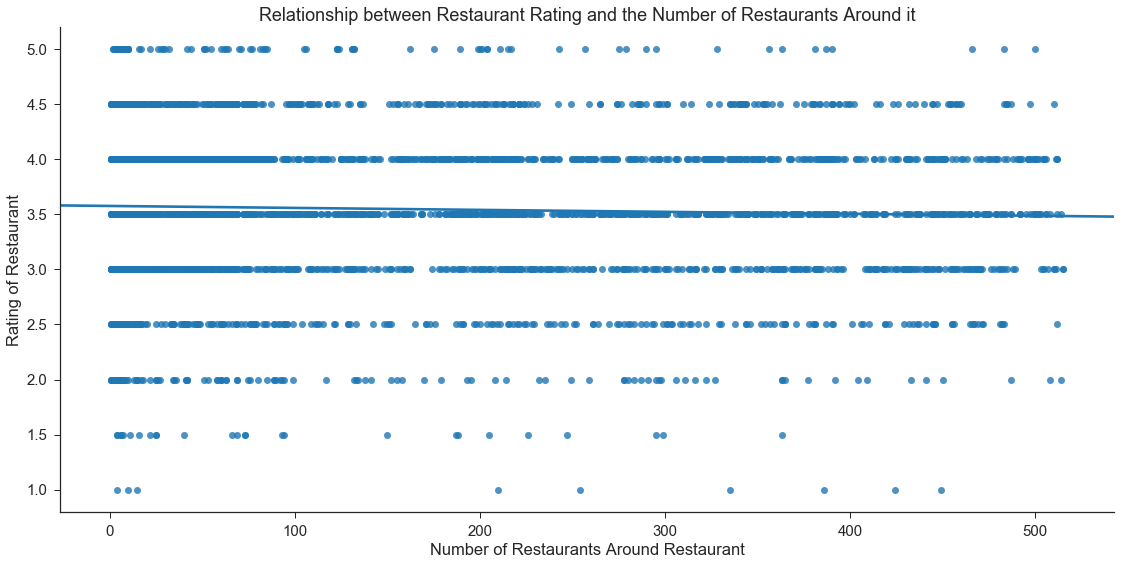

In [28]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="restaurant_count", y="rating", size=8, ci=None, data=restaurant_count_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Restaurant Rating and the Number of Restaurants Around it")
plt.xlabel('Number of Restaurants Around Restaurant')
plt.ylabel('Rating of Restaurant')

In [29]:
not_restaurant_count_df = pd.DataFrame()

def haversine(x):
    
    global not_restaurant_df
    global not_restaurant_count_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_restaurant_df['latitude']), np.radians(not_restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_restaurant_df
    measure_1 = measure_1.loc[not_restaurant_df['distance'] <=1]
    
    # Calculate the number of pubs
    not_restaurant_count = len(measure_1.index)
    #density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    not_restaurant_count_df = not_restaurant_count_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'not_restaurant_count':not_restaurant_count}, ignore_index=True)
    return not_restaurant_count_df


for line in not_restaurant_df['index_no']:
    x = not_restaurant_df.loc[not_restaurant_df['index_no'] == line]
    haversine(x)


In [ ]:
#business_count_df = business_count_df[(business_count_df.rating >= 2) & (business_count_df.pub_count <= 175)]
#business_count_df = business_count_df[(business_count_df.rating >= 2.4)]


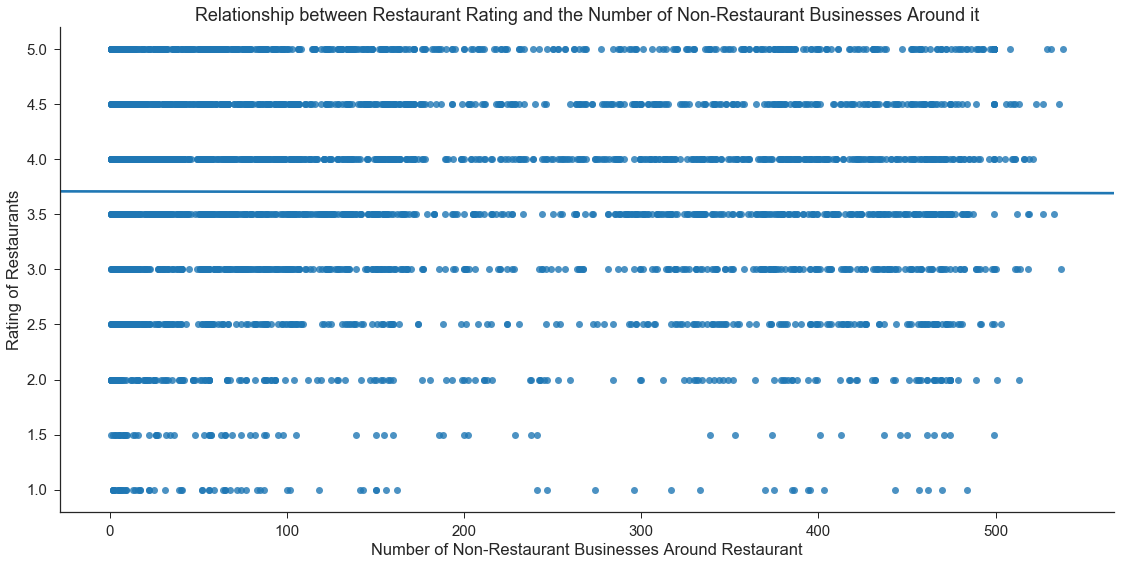

In [31]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="not_restaurant_count", y="rating", size=8, ci=None, data=not_restaurant_count_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Restaurant Rating and the Number of Non-Restaurant Businesses Around it")
plt.xlabel('Number of Non-Restaurant Businesses Around Restaurant')
plt.ylabel('Rating of Restaurants')